## Importing necessary libraries

In [336]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler


In [337]:
## Adding a function for baseline prediction and F1 score

def imbalancing(df,target_variable,percentage):
  df = df.sort_values(target_variable, axis=0,ascending=True)
  x, y = df[target_variable].value_counts(ascending=True)
  n = x * 100 / percentage
  return df.head(math.floor(n))

def baseline_prediction(data, target_variable):
  x = data.drop(labels= target_variable, axis=1)
  y = data[target_variable]

  classifier_baseline = RandomForestClassifier()
  baseline_scores = cross_val_score(classifier_baseline, x, y, cv=10, scoring = 'f1')
  print("Baseline f1 score: %0.3f +/- %0.3f" % (baseline_scores.mean(), baseline_scores.std()))

In [338]:
## Creating a class that has functions to plot various visualizations 
class imbalance_dataset():
  def __init__(self, dataset):
    self.d = dataset
  
  # Plotting histogram
  def hist(self, width=20, height=7):
    _ = self.d.hist(bins=50, figsize=(width,height))
  # Plotting heat map with correlation
  def heatmap(self, width=20, height=8):
    correlations = self.d.corr()
    f, ax = plt.subplots(figsize=(width, height))
    ax = sns.heatmap(correlations, annot=True, center=0,  cmap="BuPu")
  # Plot box plot
  def box(self, width=20, height=8):
    f, ax = plt.subplots(figsize=(width, height))
    column = list(self.d.columns)
    ax = self.d.boxplot(column= column)

  def replace(self, label):
    self.d.replace(label, inplace=True)

In [339]:
# Adding a function for classification
def classification(data,target_variable):
  sk_fold = StratifiedKFold(n_splits = 10) #Splitting data into 10 folds
  x = data.drop(labels=target_variable, axis=1).values
  y = data[target_variable].values

  f1 = []
  for training, testing in sk_fold.split(x, y):
    #Assigning data to train and test data in 9 folds
    x_train = x[training]
    x_test = x[testing]
    y_train = y[training]
    y_test = y[testing]
    

    


    # Running the training data in order to get the optimal number of clusters with maximun silhouette score
    inertias, sil_houette = [], []
    for i in range(1, 12):
        kmeans = KMeans(n_clusters=i)
        y_pred = kmeans.fit_predict(x_train)
        inertias.append(kmeans.inertia_)
        if i > 1:
            sil_houette.append(silhouette_score(x_train, y_pred))
    i = sil_houette.index(max(sil_houette))+2
    
    # Running kmeans algorithm with the optimal number of clusters
    kmeans = KMeans(n_clusters=i, random_state=1)
    y_kmeans = kmeans.fit_predict(x_train)
    
    pred_ = np.zeros(len(y_test))
    for rf in range(i):                         # RF classifier for each cluster from KMeans
      index = np.where(y_kmeans == rf)     
      y_kmeans_cluster = y_train[index]          
      x_train_cluster = x_train[index]          
      random_cluster = RandomForestClassifier()
      random_cluster.fit(x_train_cluster, y_kmeans_cluster)

      y_pred = kmeans.predict(x_test)           # predict the cluster from test data
      
      for j in range(len(y_pred)):              # run the random forest to identify the class in each cluster
        if y_pred[j] == rf:
          pred_[j] = random_cluster.predict(np.reshape(x_test[j], (1,len(data.columns)-1)))

    f1.append(f1_score(y_test,pred_)) # Saving the F1 score in a list

  return f1, i

## Importing gender classfication data sets 

In [340]:
df1=pd.read_csv("gender_classification_v7.csv") 
df1.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


## Exploring and cleaning the data set 

In [341]:
df1=imbalance_dataset(df1)


In [342]:
df1.d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB


No columns have missing values. Most columns are numerical (int64 or float64). Column 'gender' is of type 'object', which, as it comes from a csv file, typically means strings. It looks like it's a categorical feature, so we'll check how many categories there are and how many examples for each.

In [343]:
# grouping the data into two classes
label = {'gender':{'Male':0, 'Female':1,}}
df1.replace(label)
df1.d.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,0
1,0,14.0,5.4,0,0,1,0,1
2,0,11.8,6.3,1,1,1,1,0
3,0,14.4,6.1,0,1,1,1,0
4,1,13.5,5.9,0,0,0,0,1


In [344]:
df1.d['gender'].value_counts()

1    2501
0    2500
Name: gender, dtype: int64

Now let's do some checks of the numerical columns.

In [345]:
df1.d.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.00000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900,0.50010
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049,0.50005
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000,1.00000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000,1.00000


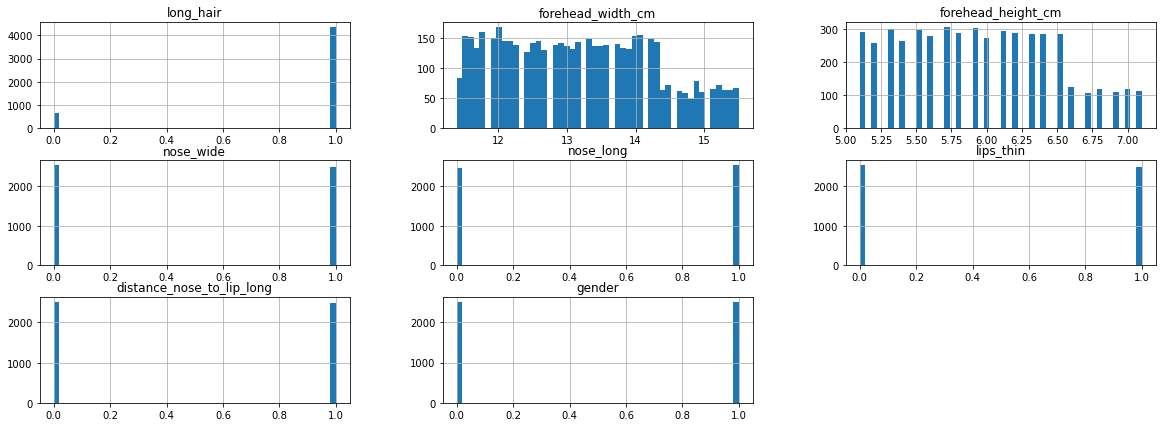

In [346]:
df1.hist()

Here are some insights:

- 'long_hair', 'nose_wide', 'nose_long', 'lips_thin', and 'distance_nose_to_lip_long' appear as numerical features, but they are categorical.
- apart from 'long_hair' all the categorical values seem to be balanced and have equal no.of 0s and 1s.



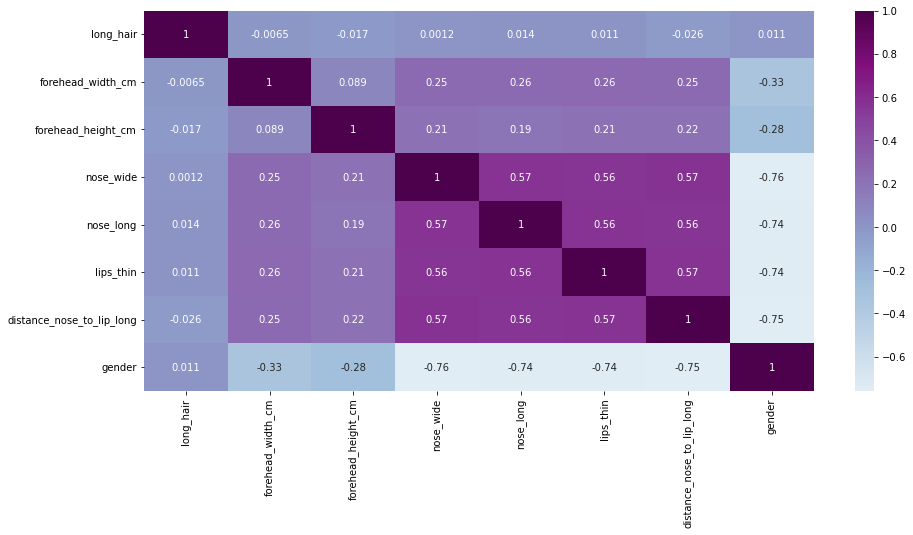

In [347]:
# Correlations and Heatmap
df1.heatmap(15,7)

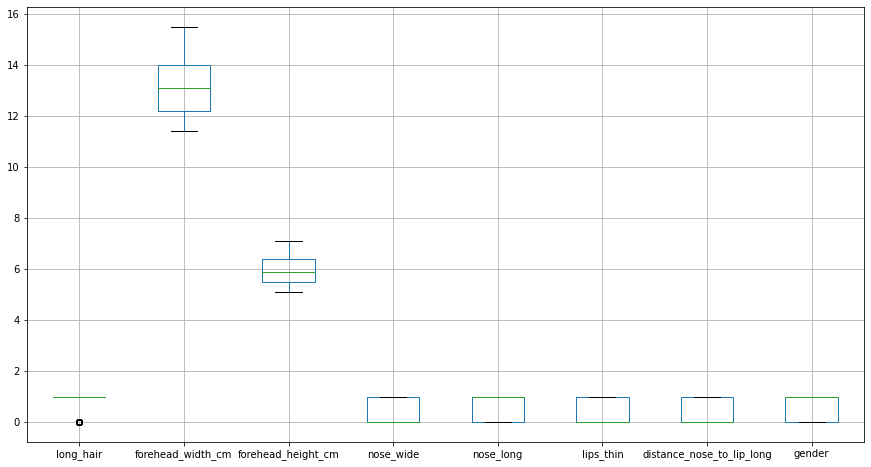

In [348]:
df1.box(15,8)

## Low Imbalance for gender classification data set

In [349]:
df1_low = imbalancing(df1.d,'gender',65)
df1_low['gender'].value_counts()

0    2500
1    1346
Name: gender, dtype: int64

## Medium Imbalance for gender classification data set

In [350]:
df1_medium = imbalancing(df1.d,'gender',75)
df1_medium['gender'].value_counts()

0    2500
1     833
Name: gender, dtype: int64

## High imbalance on gender classification data set

In [351]:
df1_high = imbalancing(df1.d,'gender',90)
df1_high['gender'].value_counts()

0    2500
1     277
Name: gender, dtype: int64

## Baseline predicition 

In [352]:
baseline_prediction(df1_low,'gender')

Baseline f1 score: 0.957 +/- 0.011


In [353]:
baseline_prediction(df1_medium,'gender')

Baseline f1 score: 0.944 +/- 0.014


In [354]:
baseline_prediction(df1_high,'gender')

Baseline f1 score: 0.921 +/- 0.018


## Random Forest Predicition

In [355]:
score, k = classification(df1_low,'gender')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 3 clusters: 0.953 +/- 0.009


In [356]:
score, k = classification(df1_medium,'gender')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.942 +/- 0.015


In [357]:
score, k = classification(df1_high,'gender')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.914 +/- 0.034


## Importing wine quality-red  dataset

In [358]:
df2=pd.read_csv("winequality-red.csv")
df2.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [359]:
df2=imbalance_dataset(df2)

In [360]:
df2.d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


No columns have missing values. All columns are numerical (float64).

In [361]:
df2.d['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [362]:
# changing the target variable into numeric data
# Anything above 5 is good quality denoted by 1 and anything below 5 is bad quality denoted by 0.
label = {'quality':{3:0, 4:0,5:0,6:1,7:1,8:1}}
df2.replace(label)
df2.d.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [363]:
df2.d['quality'].value_counts()

1    855
0    744
Name: quality, dtype: int64

Now let's do some checks of the numerical columns.

In [364]:
df2.d.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


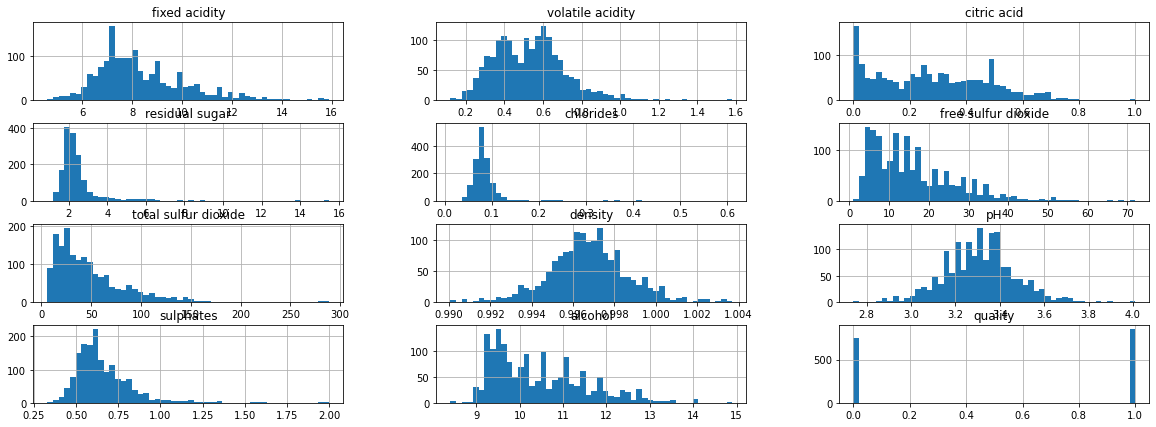

In [365]:
df2.hist()

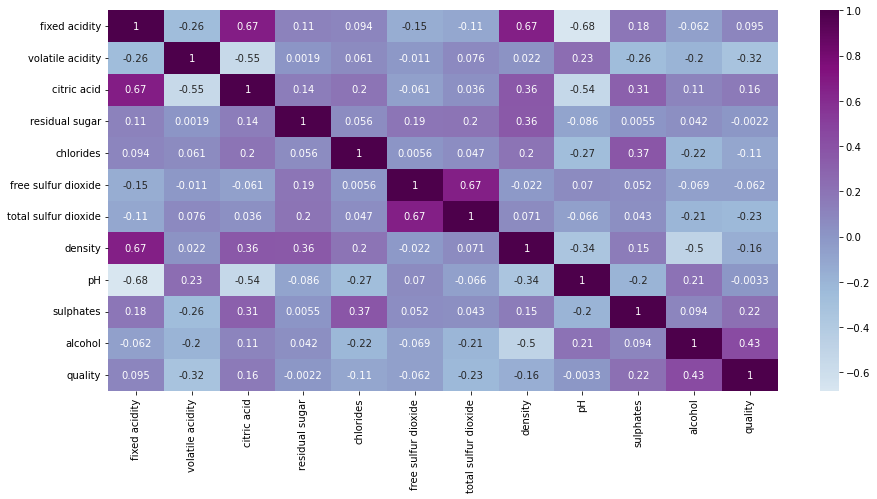

In [366]:
#Correlations and heatmap
df2.heatmap(15,7)

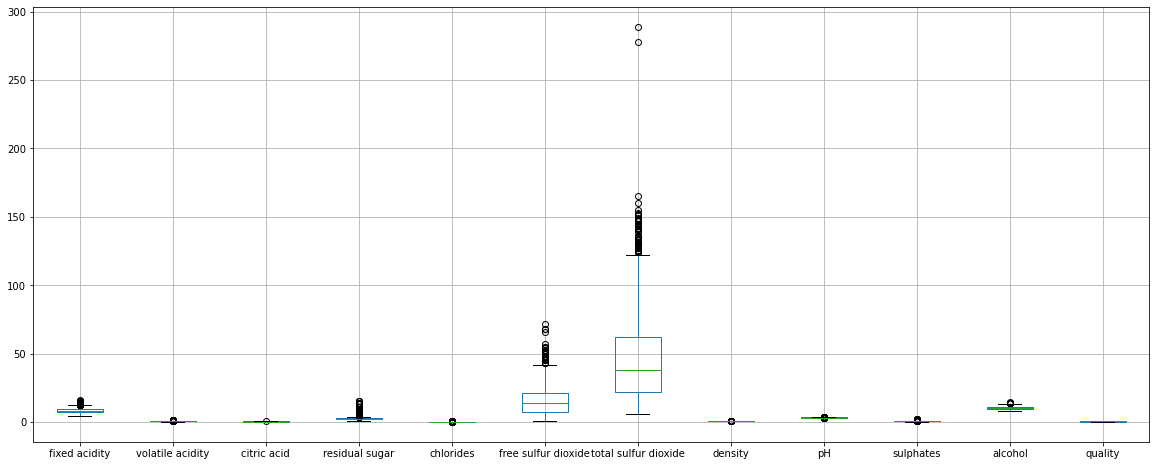

In [367]:
df2.box()

## Low imbalance on wine quality set

In [368]:
df2_low = imbalancing(df2.d,'quality',65)
df2_low['quality'].value_counts()

0    744
1    400
Name: quality, dtype: int64

## Medium imbalance on wine quality data set

In [369]:
df2_medium = imbalancing(df2.d,'quality',75)
df2_medium['quality'].value_counts()

0    744
1    248
Name: quality, dtype: int64

## High imbalance on wine quality data set

In [370]:
df2_high = imbalancing(df2.d,'quality',90)
df2_high['quality'].value_counts()

0    744
1     82
Name: quality, dtype: int64

## Baseline Prediction

In [371]:
baseline_prediction(df2_low,'quality')

Baseline f1 score: 0.719 +/- 0.069


In [372]:
baseline_prediction(df2_medium,'quality')

Baseline f1 score: 0.703 +/- 0.081


In [373]:
baseline_prediction(df2_high,'quality')

Baseline f1 score: 0.544 +/- 0.160


In [374]:
score, k = classification(df2_low,'quality')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.714 +/- 0.068


In [375]:
score, k = classification(df2_medium,'quality')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.689 +/- 0.085


In [376]:
score, k = classification(df2_high,'quality')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.523 +/- 0.120


## Importing heart attack dataset

In [377]:
df3=pd.read_csv("heart.csv")
df3.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [378]:
df3=imbalance_dataset(df3)

In [379]:
df3.d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


No columns have missing values. ALl the columns are numerical (int64 or float64).

In [380]:
df3.d['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

In [381]:
df3.d.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


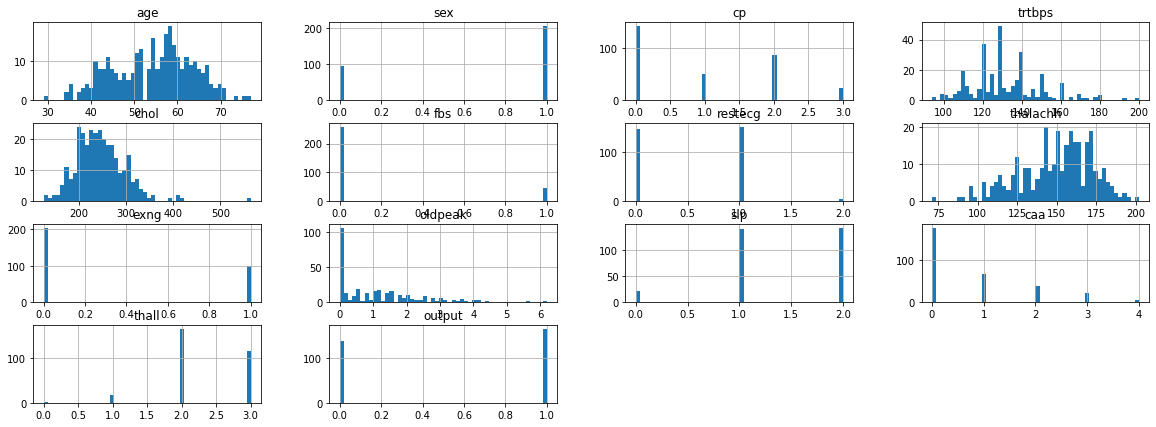

In [382]:
df3.hist()

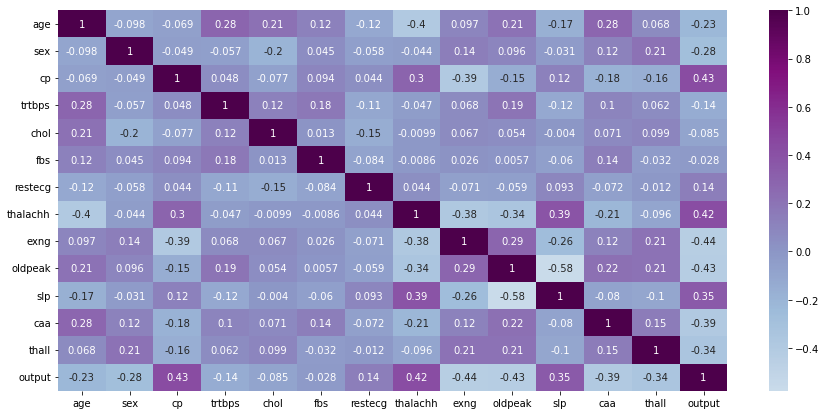

In [383]:
df3.heatmap(15,7)

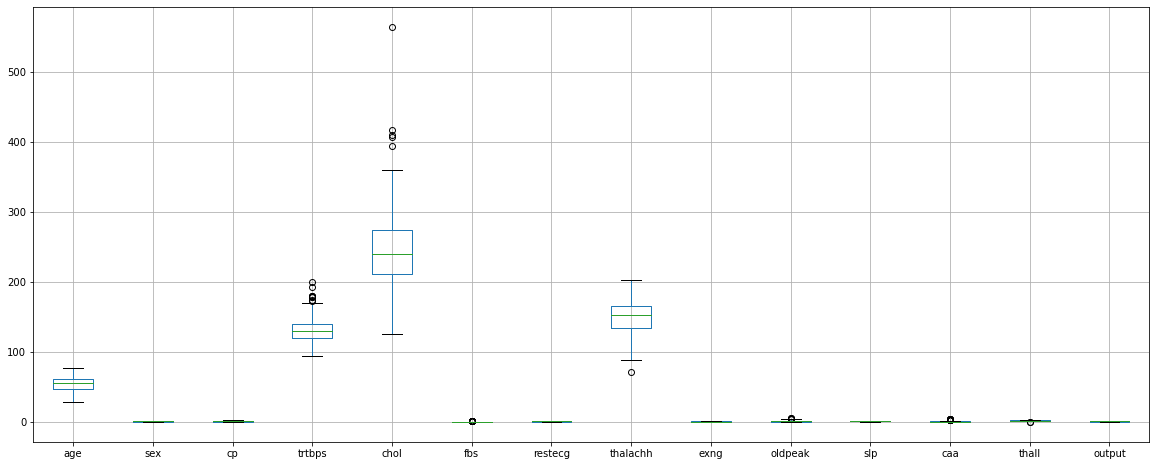

In [384]:
df3.box()

Here is an insight:
'sex', 'fbs', 'restecg', 'exng', and 'output' appear as numerical features, but they are categorical.



## Low imbalance on heart attack data set

In [385]:
df3_low = imbalancing(df3.d,'output',65)
df3_low['output'].value_counts()

0    138
1     74
Name: output, dtype: int64

## Medium imbalance on heart attack data set

In [386]:
df3_medium = imbalancing(df3.d,'output',75)
df3_medium['output'].value_counts()

0    138
1     46
Name: output, dtype: int64

## High imbalance on heart attack data set

In [387]:
df3_high = imbalancing(df3.d,'output',90)
df3_high['output'].value_counts()

0    138
1     15
Name: output, dtype: int64

## Baseline prediction

In [388]:
baseline_prediction(df3_low,'output')

Baseline f1 score: 0.738 +/- 0.117


In [389]:
baseline_prediction(df3_medium,'output')

Baseline f1 score: 0.686 +/- 0.158


In [390]:
baseline_prediction(df3_high,'output')

Baseline f1 score: 0.433 +/- 0.448


In [391]:
score, k = classification(df3_low,'output')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.756 +/- 0.112


In [392]:
score, k = classification(df3_medium,'output')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.636 +/- 0.168


In [393]:
score, k = classification(df3_high,'output')
print("F1 score for %d clusters: %0.3f +/- %0.3f" % (k, np.mean(score), np.std(score)))

F1 score for 2 clusters: 0.533 +/- 0.452
